In [1]:
import sys
import build_datasets
import machine_learning
import feature_extraction
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import operator
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

BLE_CLASSIC_TOGGLE='classic'

pad = build_datasets.pad

# ===============================
# Load or rebuild datasets

all_sources_files = build_datasets.find_sources()
if BLE_CLASSIC_TOGGLE == 'ble':
    all_sources_files = [s for s in all_sources_files if not "Samsung" in s and not "Fossil" in s]
else:
    all_sources_files = [s for s in all_sources_files if "Samsung" in s or "Fossil" in s]
build_datasets.rebuild_all_datasets(all_sources_files, force_rebuild=True)

Common columns: ['Communication', 'LAP', 'Transmitter', 'Originator', 'Item', 'Application', 'Time delta', 'Packet Type', 'Payload', 'Status', 'Receiver', 'Packet #', 'Time']
Loading and cleaning dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_1.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_2.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_3.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_4.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_5.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_1.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_2.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_3.csv
Loading and cleaning dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_4.csv
Loading and cleaning dataset data/FossilExploristHR_

Dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_1.csv contains 144 packets
Dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_2.csv contains 152 packets
Dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_3.csv contains 143 packets
Dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_4.csv contains 130 packets
Dataset data/FossilExploristHR_NoApp_Idle_Classic_enc_5.csv contains 135 packets
Dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_1.csv contains 2737 packets
Dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_2.csv contains 2311 packets
Dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_3.csv contains 2349 packets
Dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_4.csv contains 1242 packets
Dataset data/FossilExploristHR_NoApp_PhoneCallMissed_Classic_enc_5.csv contains 2616 packets
Dataset data/SamsungGWatch_Endomondo_Run_Classic_enc_1.csv contains 6550 packets
Dataset data/SamsungGWatch_Endomondo_Run_Classic_

In [2]:
def cut_in_events(xy_features, timeout=4.5):
    """
    Returns [[(time, size)],] where each list is separated by at least timeout time, from a given [(time,size)]
    """
    events = []
    def trim_and_add_event(start, end):
        start_trim = start
        while ys[start_trim] == 0 :
            start_trim += 1
            if start_trim >= len(ys):
                return None
        end_trim = end
        while ys[end_trim] == 0 :
            end_trim -= 1

        if start_trim > end_trim:
            print("You broke the matrix", start, end, start_trim, end_trim, len(xs), len(ys))
            sys.exit(1)

        xs_copy = xs[start_trim:end_trim]
        ys_copy = ys[start_trim:end_trim]
        events.append(dict(xs=xs_copy, ys=ys_copy))
        

    xs = xy_features['xs']
    ys = xy_features['ys']

    feature_start = 0
    last_activity_index = -1  # not even one activity seen yet, never create an event in this case
    index = 0

    while index < len(xs):

        if last_activity_index != -1 and xs[index] - xs[last_activity_index] > timeout:
            trim_and_add_event(feature_start, index)

            feature_start = index
            last_activity_index = -1 # not even one activity seen yet

        if ys[index] > 0:
            last_activity_index = index
        index += 1

    # don't forget the last event
    if feature_start < len(xs)-1:
        trim_and_add_event(feature_start, len(xs)-1)

    events = [e for e in events if e is not None]
    return events

In [3]:
def show_cutting(source_file, timeout=10):
    xy_uncut = build_datasets.dataset_file_to_xy_features(source_file)
    xy_events = cut_in_events(xy_uncut, timeout=timeout)
    
    plt.plot(xy_uncut['xs'], xy_uncut['ys'], label='Uncut')
    for i in range(len(xy_events)):
        plt.plot(xy_events[i]['xs'], xy_events[i]['ys'], label=str(i))
    plt.xlabel('Time [s]')
    plt.ylabel('Packet size [B]')
    plt.title(source_file)
    plt.legend()
    plt.xlim(0,45)
    #plt.ylim(0.8,1.4)
    plt.show()

======================================= FossilExploristHR NoApp Idle


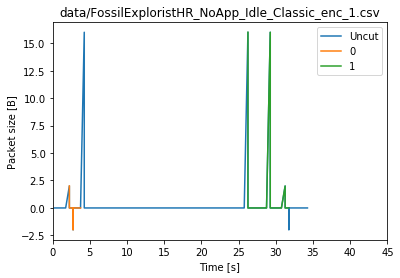

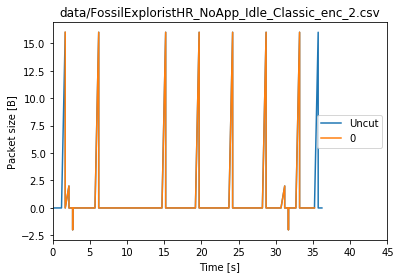

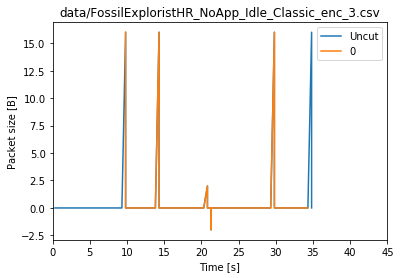

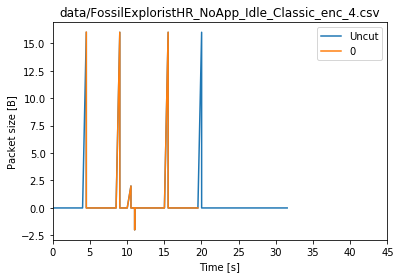

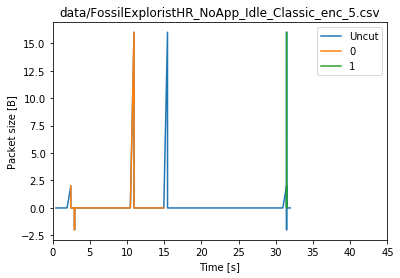

======================================= FossilExploristHR NoApp PhoneCallMissed


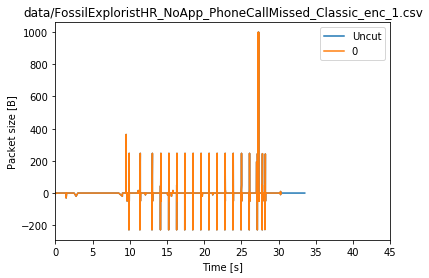

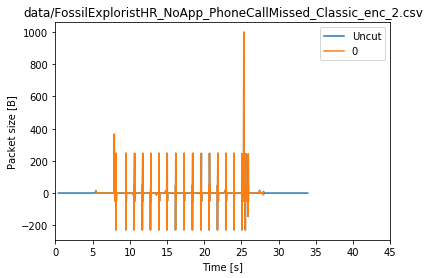

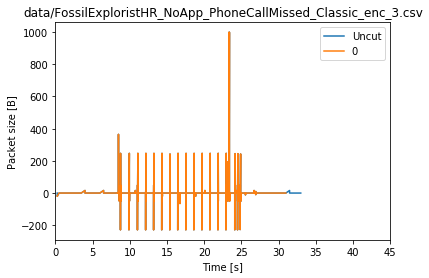

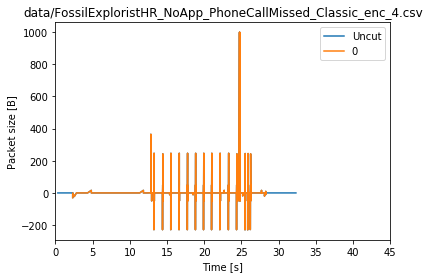

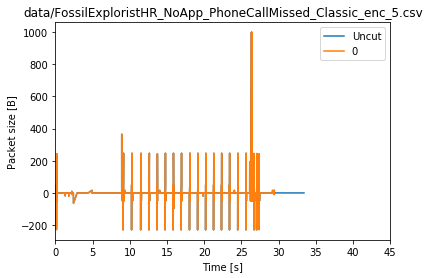

======================================= SamsungGWatch Endomondo Run


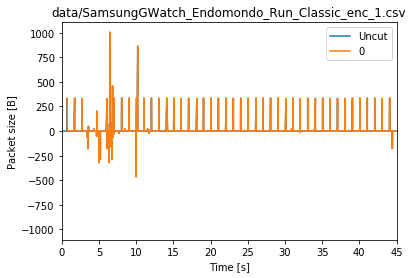

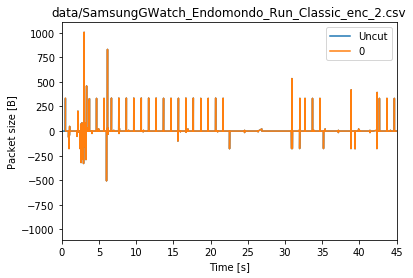

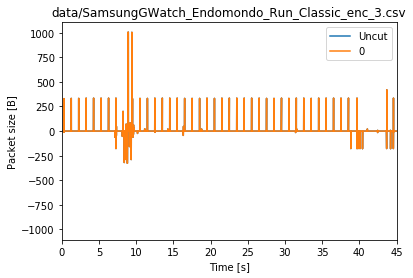

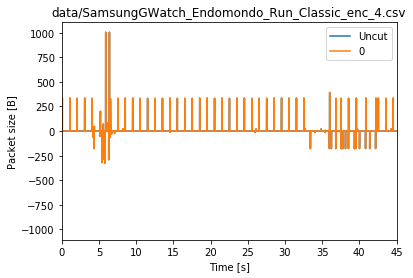

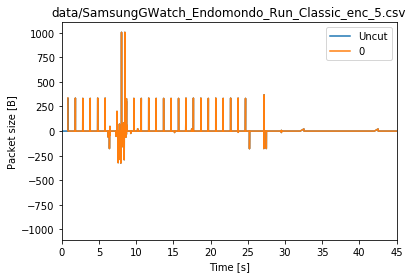

======================================= SamsungGWatch Endomondo Walk


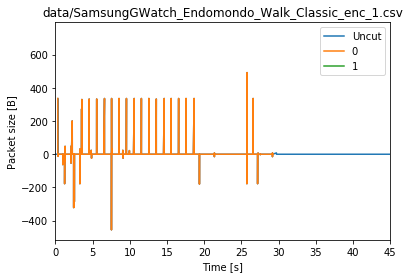

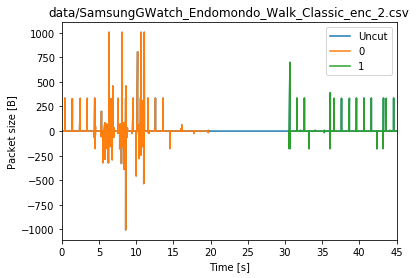

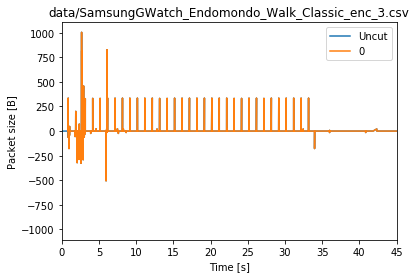

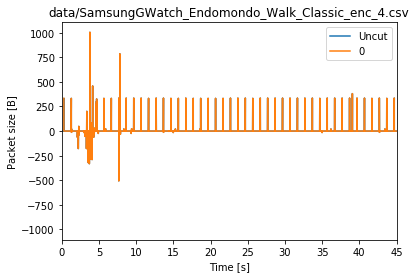

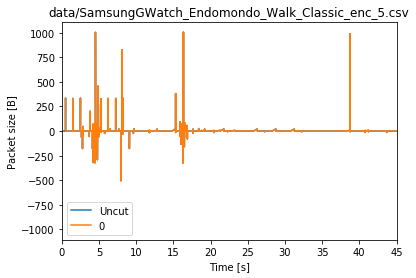

======================================= SamsungGWatch FITIV Run


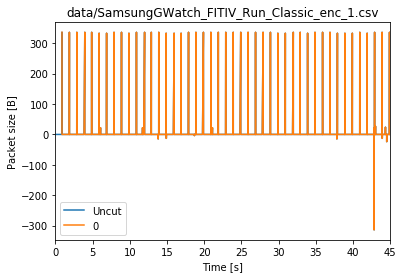

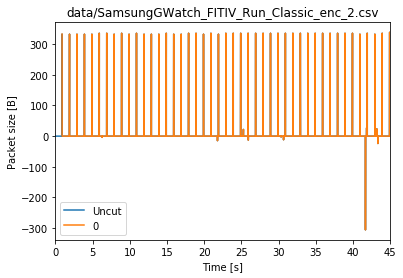

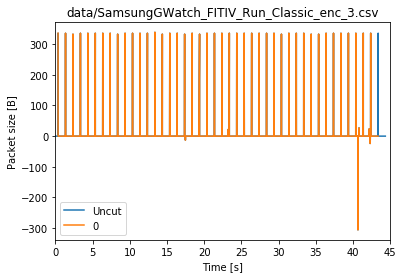

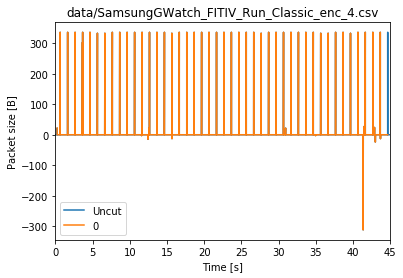

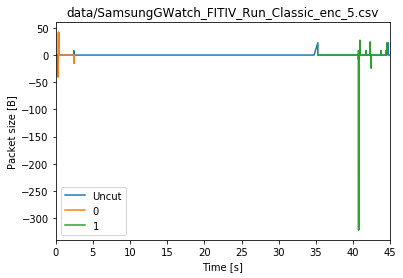

======================================= SamsungGWatch FITIV Walk


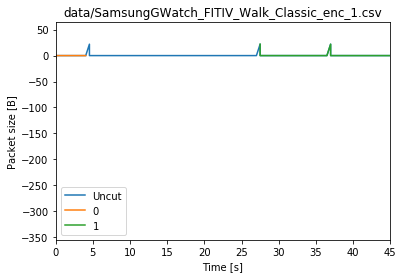

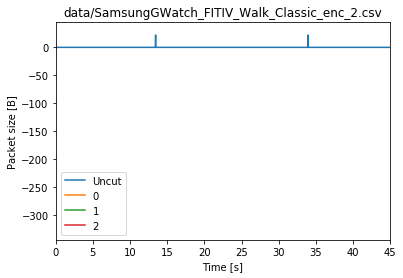

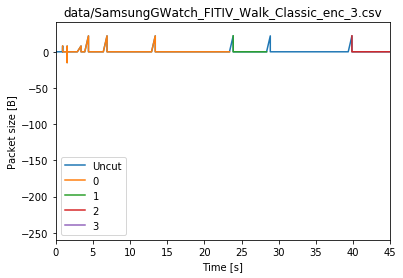

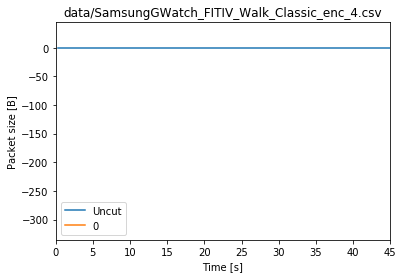

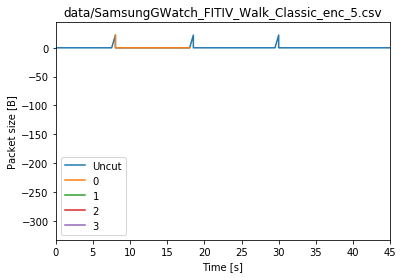

======================================= SamsungGWatch MapMyRun Run


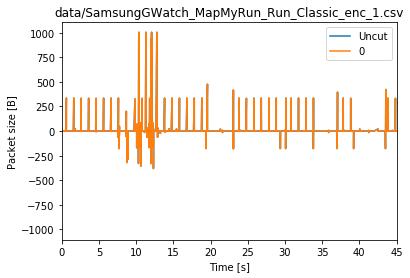

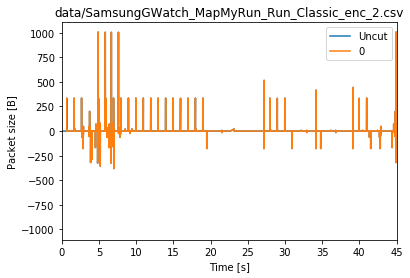

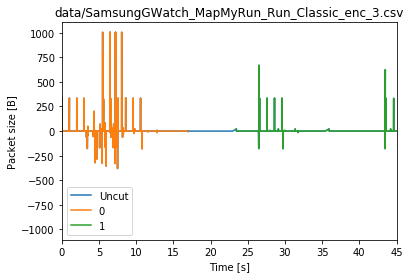

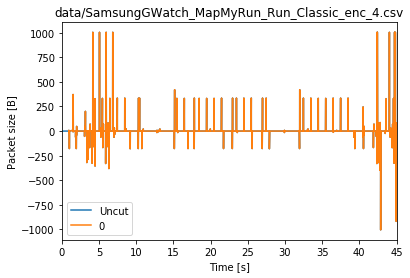

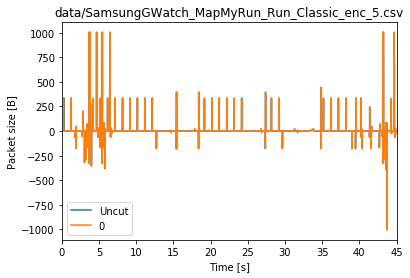

======================================= SamsungGWatch MapMyRun Walk


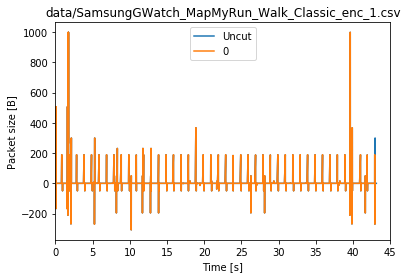

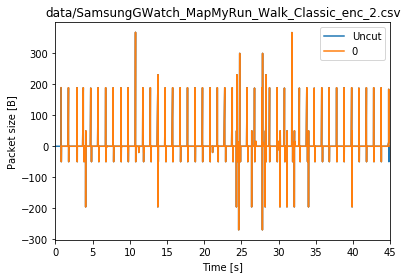

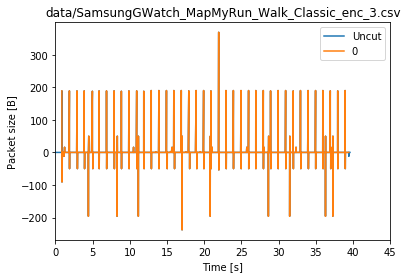

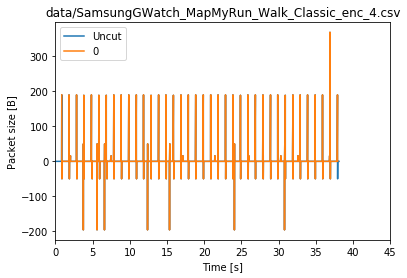

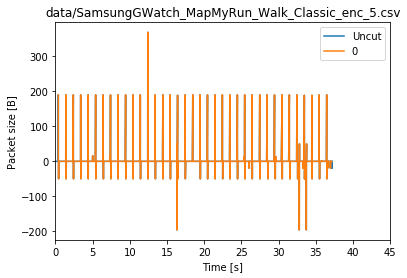

======================================= SamsungGWatch MyFitnessPal CaloriesAdd


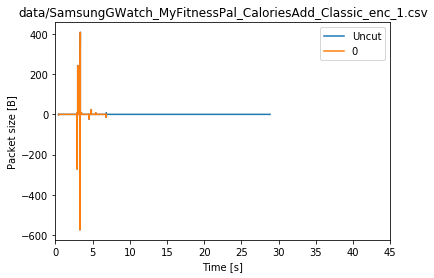

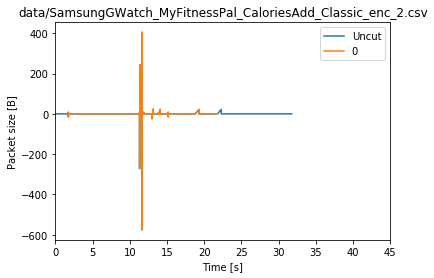

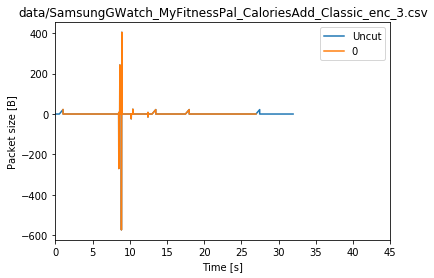

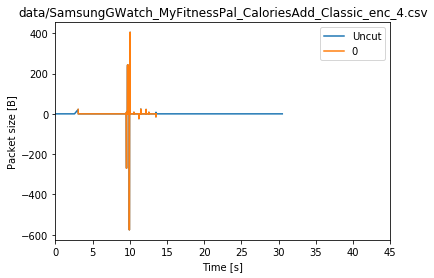

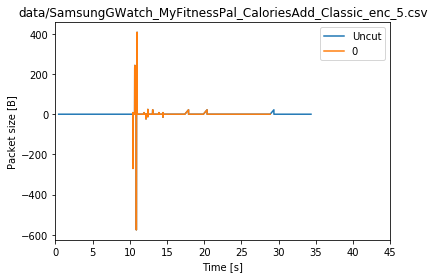

======================================= SamsungGWatch MyFitnessPal WaterAdd


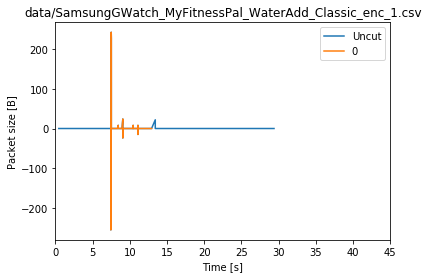

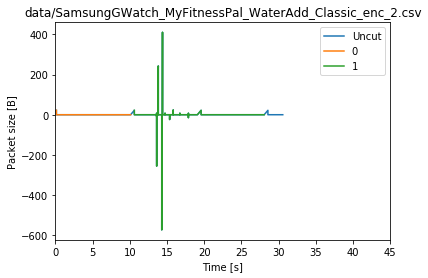

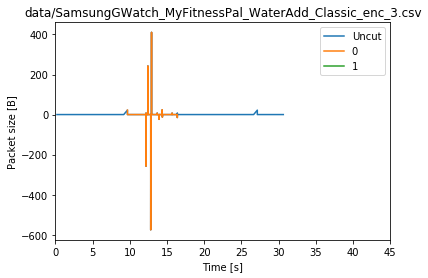

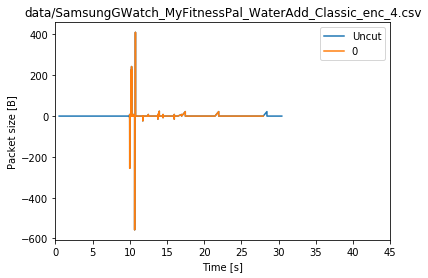

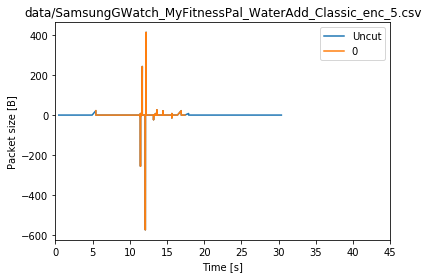

======================================= SamsungGWatch NoApp Email


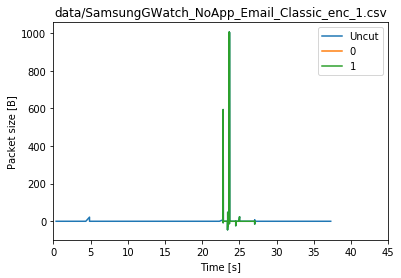

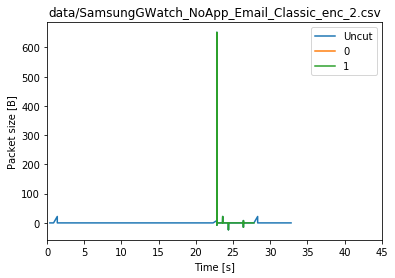

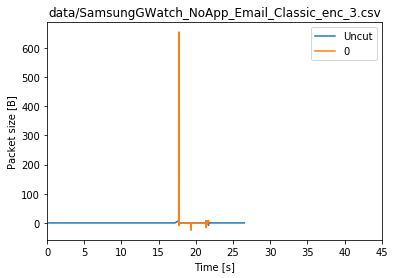

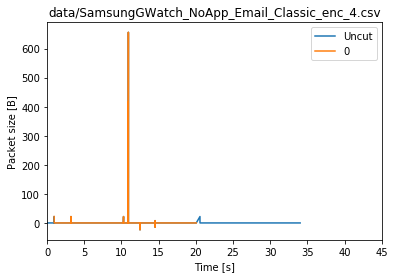

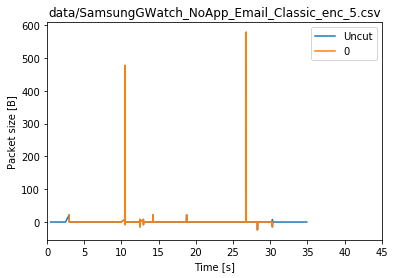

======================================= SamsungGWatch NoApp PhoneCallMissed


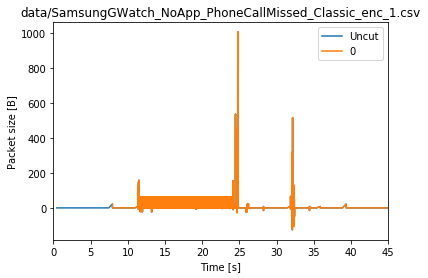

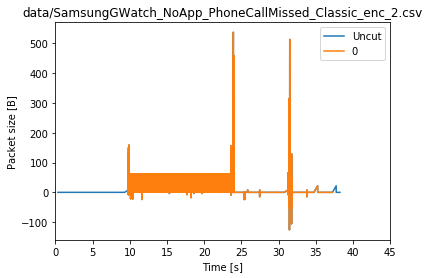

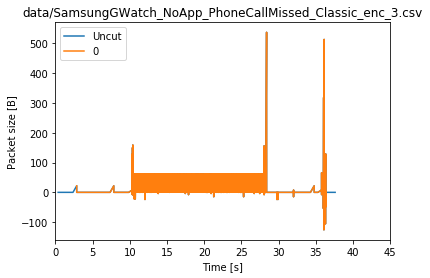

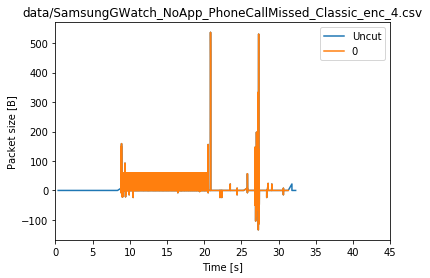

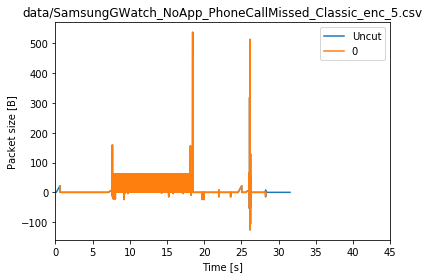

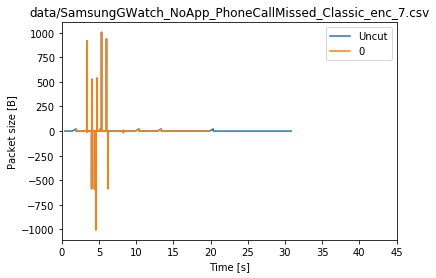

======================================= SamsungGWatch NoApp PhotoTransfer


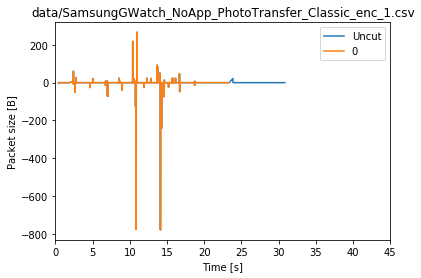

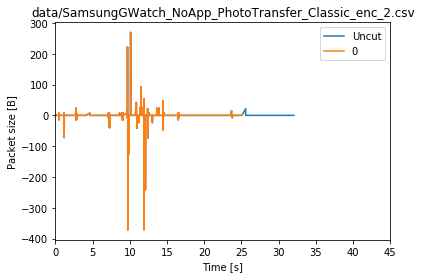

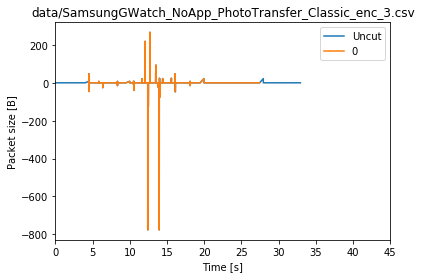

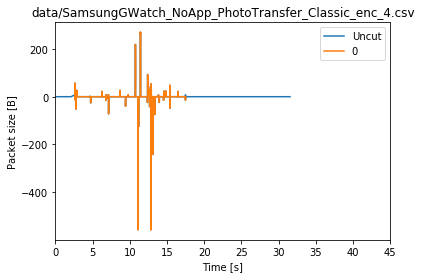

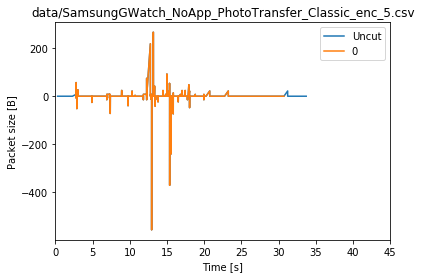

======================================= SamsungGWatch NoApp SmsReceivedOnPhone


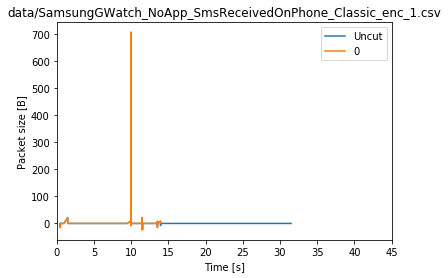

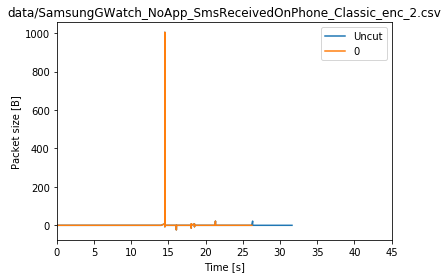

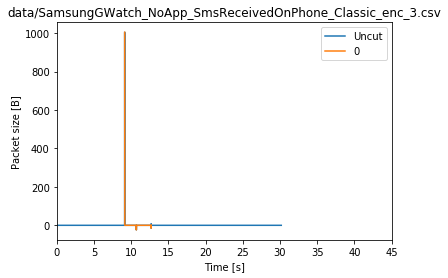

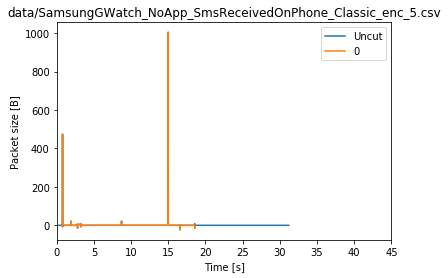

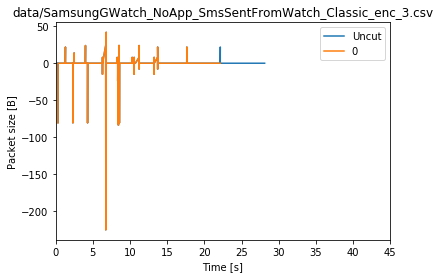

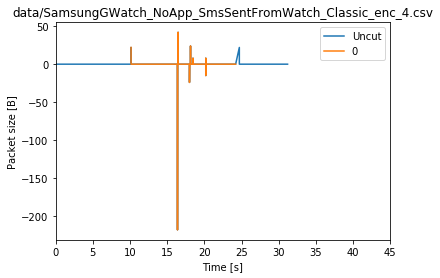

======================================= SamsungGWatch Pear Run


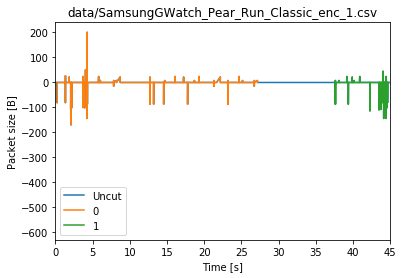

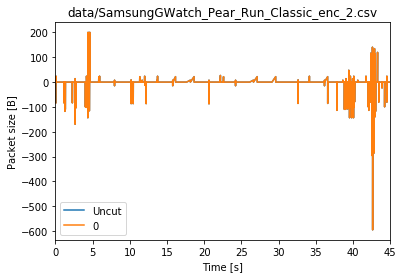

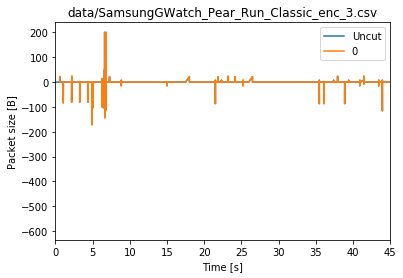

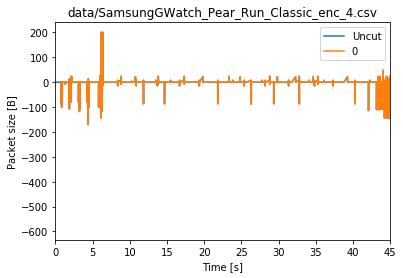

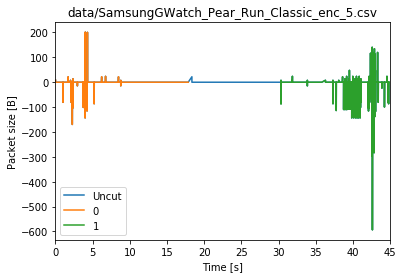

======================================= SamsungGWatch Pear Walk


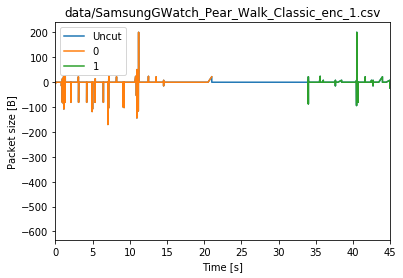

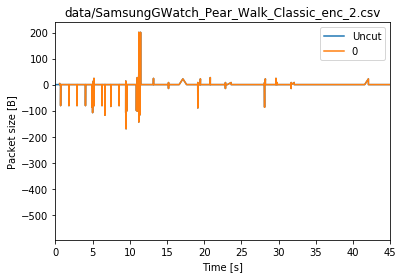

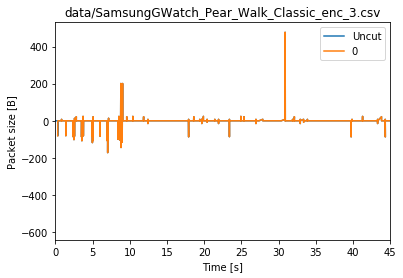

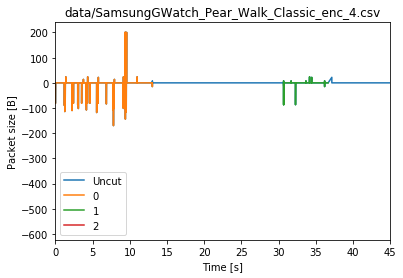

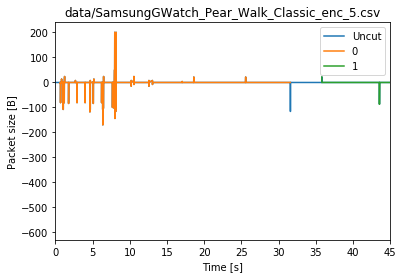

======================================= SamsungGWatch SamsungHealth HeartRateStressTest


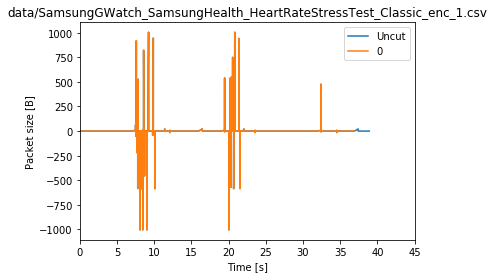

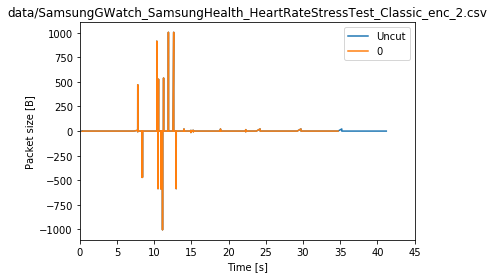

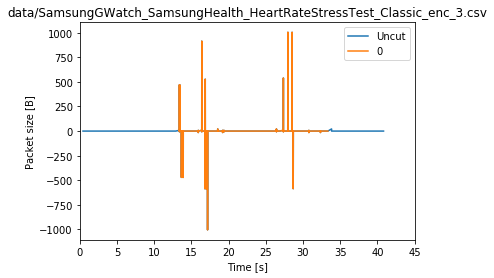

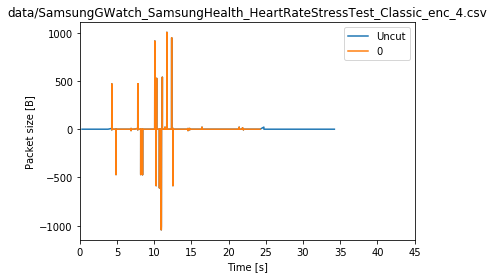

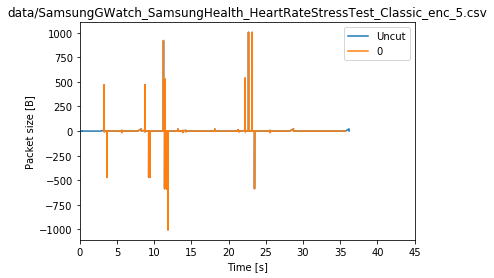

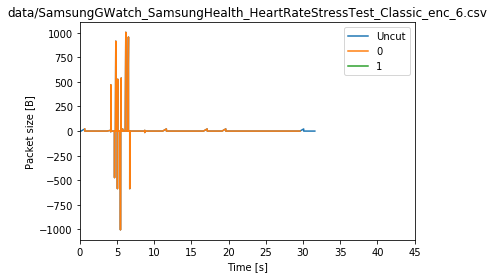

======================================= SamsungGWatch SamsungHealth Run


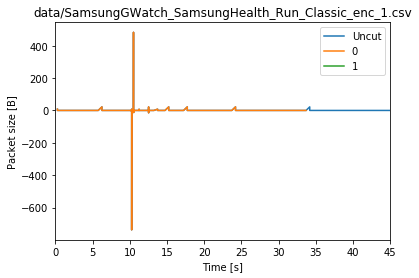

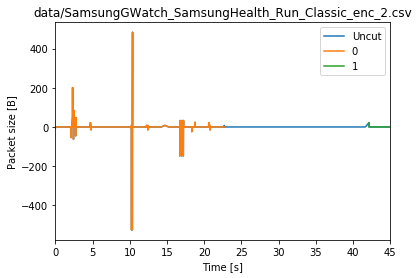

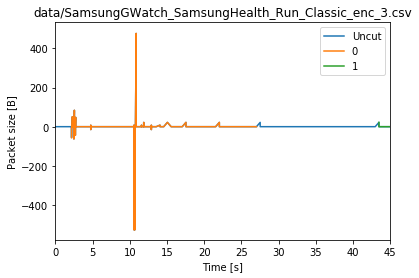

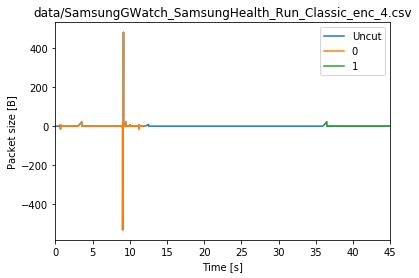

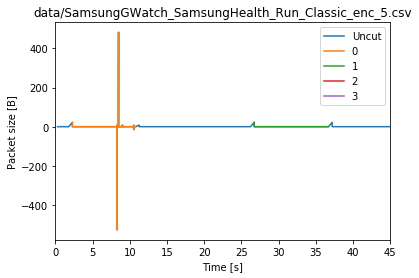

======================================= SamsungGWatch SamsungHealth Walk


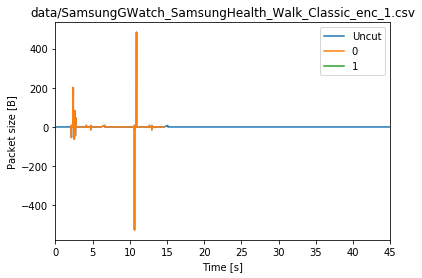

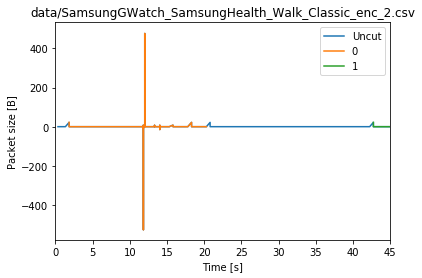

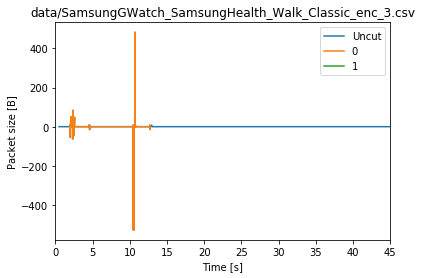

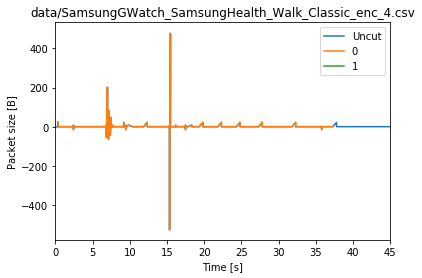

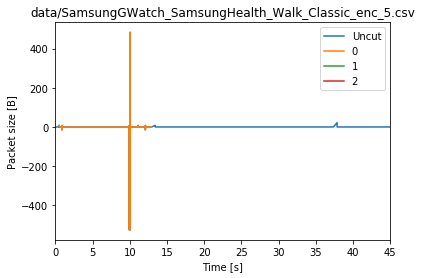

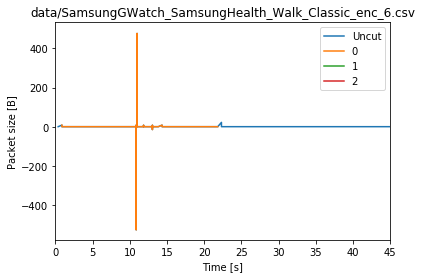

In [4]:
for s in all_sources_files:
    [device, app, action, ble, pl, repeat] = s.replace('data/', '').replace('.csv', '').split('_')
    if repeat == "1":
        print("=======================================", device, app, action)
    show_cutting(s, timeout=10)